# Notebook containing code to produce the figures and stats in the paper

- Figure 2: Encoding performance
    - Fig 2A: points by index relative to boundary
    - Fig 2B: rt by index relative to boundary
    - Fig 2C: post-error slowing by index relative to boundary

- Figure 3: Recall performance
    - Fig 3A: Serial position curve
    - Fig 3B: CRP

- Figure 4: Evidence for boundary effects
    - Fig 4A: recall by boundary label

- Figure 5: Boundarys/events organize recall
    - Fig 5A: Event CRP
    - Fig 5B: Probability of transitioning to new event (steppingstone)
    - Fig 5C: Clustering using ARC

- Figure 6: RL model
    - Fig 6A: RPE by trial number in encoding task
    - Fig 6B: RPE to memory predictions


Running this notebook will regenerate the figures and stats in the main text of the paper.



## Setup

The following blocks load some libraries and set some parameters for the remainder of the notebook.

They also load the data from the experiment and the model fits to generate the figures and stats.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import seaborn as sns
import pingouin as pg
from psifr import fr
import sys

sys.path.append("../../")
from pymer4 import Lmer, Lm

sns.set_theme(style="white", context="paper")
from itertools import combinations
from src.data.process_strat import *


red = "#e41a1c"
green = "#4daf4a"

# make a palette for incorrect and correct
pal = [red, green]

In [24]:
strat_df = pd.read_csv("../../data/processed/DecayFeatureRL_strat_data_rpe.csv")
rl_df = pd.read_csv("../../data/processed/DecayFeatureRL_no_resp_st_results.csv")
fr_df = pd.read_csv("../../data/interim/mem_df.csv")

/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_22341/482961266.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  strat_df = pd.read_csv("../../data/processed/DecayFeatureRL_strat_data_rpe.csv")


In [25]:
# get rid of people with fewer than 15 words recalled
fr_df = fr_df.dropna(subset=["word"])
fr_df["recalled"] = fr_df["recall"] & fr_df["study"]
recalls = fr_df.groupby(["subject", "list"])["recalled"].sum()

# Find subjects with less than 5 recalls per list
bad_subs = set(recalls[recalls < 1].reset_index()["subject"])
print(len(bad_subs))
fr_df = fr_df[~fr_df["subject"].isin(bad_subs)]
strat_df = strat_df[~strat_df["sona_id"].isin(bad_subs)]
rl_df = rl_df[~rl_df["sona_id"].isin(bad_subs)]
strat_df["word"] = strat_df["word"].str.lower()

1


In [26]:
with open("../../data/processed/strat_subs.txt", "w") as f:
    for sub in strat_df.sona_id.unique().tolist():
        f.write(sub + "\n")

In [27]:
strat_df["rt_centered"] = strat_df["rt"] - strat_df.groupby(["sona_id"])[
    "rt"
].transform("mean")
strat_df["rt_z_score"] = strat_df["rt_centered"] / strat_df.groupby(["sona_id"])[
    "rt"
].transform("std")
strat_df["rt_shift"] = strat_df.groupby(["sona_id", "run"])["rt"].shift(-1)

In [28]:
strat_df = strat_df.merge(
    rl_df[
        [
            "sona_id",
            "eta",
        ]
    ],
    on="sona_id",
)
strat_df.head()

,Unnamed: 0,index,view_history,rt,trial_type,trial_index,time_elapsed,internal_node_id,run_id,condition,...,item_rule_idx1,inv_item_rule_idx0,inv_item_rule_idx1,rpe,trial_by_trial_loglik,uncertainty,rt_centered,rt_z_score,rt_shift,eta
0,0,19047,NaN,NaN,html-keyboard-response,14,1124352,0.0-3.0-0.0-0.0,132,1,...,1,0,0,NaN,0.000000,-0.000000,NaN,NaN,1559.0,0.089219
1,1,19051,NaN,1559.0,html-keyboard-response,18,1127922,0.0-3.0-0.1-0.1,132,1,...,1,1,0,0.000000,-5.048029,-1.000000,501.381166,1.189103,2684.0,0.089219
2,2,19055,NaN,2684.0,html-keyboard-response,22,1134070,0.0-3.0-0.2-0.2,132,1,...,0,0,1,1.000000,-0.006443,-1.000000,1626.381166,3.857214,1643.0,0.089219
3,3,19059,NaN,1643.0,html-keyboard-response,26,1138050,0.0-3.0-0.3-0.3,132,1,...,0,0,1,0.821561,-0.002625,-0.578259,585.381166,1.388322,1722.0,0.089219
4,4,19063,NaN,1722.0,html-keyboard-response,30,1143147,0.0-3.0-0.4-0.4,132,1,...,1,0,0,-0.162519,-0.006443,-1.000000,664.381166,1.575683,628.0,0.089219


In [29]:
fr_df = fr_df.merge(
    strat_df[
        [
            "sona_id",
            "word",
            "rpe",
            "trial_within_block",
            "correct_rule",
            "rt_z_score",
            "rt_shift",
            "disc",
            "item_rule",
            "within_across",
            "eta",
        ]
    ],
    on=["sona_id", "word"],
    how="left",
)

boundary_labels = {0: "Boundary", 1: "Post-Boundary", -1: "Pre-Boundary"}
fr_df["boundary_label"] = fr_df["rel_subj_boundary"].apply(
    lambda x: boundary_labels[x] if x in boundary_labels else "Non-Boundary"
)

## Overlap between subjective event boundaries and changes in latent state

In [30]:
strat_df["marker_match"] = strat_df[["rel_subj_boundary", "trial_within_block"]].apply(
    lambda x: x[0] == x[1], axis=1
)
only_bounds = strat_df[strat_df["rel_subj_boundary"] == 0]
only_bounds.groupby(["sona_id"])["marker_match"].mean().describe()
ob_gb = only_bounds.groupby(["sona_id"])["marker_match"].mean()
print(
    f"Overlap between boundary markers is mean = {np.round(ob_gb.mean(),3)}, std = {np.round(ob_gb.std(),3)}"
)

Overlap between boundary markers is mean = 0.792, std = 0.127


## Figure 2: Rule shifts reliably induce event boundaries

In [31]:
model = Lmer(
    "points ~ rel_subj_boundary*run + (1|sona_id)", data=strat_df, family="binomial"
)
model.fit()

/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "platform_version". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'str'> and <class 'float'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '
/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "response". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '
/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/rpy2/robje

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: points~rel_subj_boundary*run+(1|sona_id)

Family: binomial	 Inference: parametric

Number of observations: 16352	 Groups: {'sona_id': 73.0}

Log-likelihood: -10724.315 	 AIC: 21458.630

Random effects:

                Name    Var    Std
sona_id  (Intercept)  0.076  0.275

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.398,0.297,0.500,0.052,1.489,1.346,1.648,0.598,0.574,0.622,7.706,0.000,***
rel_subj_boundary,-0.114,-0.145,-0.084,0.016,0.892,0.865,0.920,0.471,0.464,0.479,-7.311,0.000,***
run,0.047,0.018,0.077,0.015,1.049,1.019,1.080,0.512,0.505,0.519,3.195,0.001,**
rel_subj_boundary:run,0.021,0.010,0.032,0.006,1.021,1.010,1.032,0.505,0.503,0.508,3.763,0.000,***


In [32]:
# does current rpe on trial_t predict rt_z_score on next trial?
subset_df = strat_df.copy()
subset_df = subset_df[subset_df["rt"] != -1].reset_index(drop=True)

# subset_df['boundary_label'] = subset_df['rel_subj_boundary'].apply(lambda x: boundary_labels[x] if x in boundary_labels else 'Non-Boundary')
subset_df["ispost"] = subset_df["trial_within_block"].apply(
    lambda x: 1 if x == 1 else 0
)
model = Lmer("rt ~ trial_within_block*ispost + (1|sona_id) + (1|word)", data=subset_df)
model.fit()

/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "platform_version". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'str'> and <class 'float'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '
/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "response". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '
/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/rpy2/robje

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by REML [’lmerMod’]
Formula: rt~trial_within_block*ispost+(1|sona_id)+(1|word)

Family: gaussian	 Inference: parametric

Number of observations: 16352	 Groups: {'word': 432.0, 'sona_id': 73.0}

Log-likelihood: -121813.529 	 AIC: 243639.058

Random effects:

                 Name         Var      Std
word      (Intercept)    3259.592   57.093
sona_id   (Intercept)   38277.178  195.646
Residual               223961.768  473.246

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1247.457,1199.704,1295.211,24.365,87.504,51.200,0.0,***
trial_within_block,-12.385,-16.289,-8.481,1.992,15904.110,-6.218,0.0,***
ispost,119.397,96.332,142.463,11.768,15930.130,10.146,0.0,***


/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_22341/3359802358.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  gb_df = strat_df.groupby(['sona_id','rel_subj_boundary'])['points','rt'].mean().reset_index()
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_22341/3359802358.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(),fontsize=12)
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_22341/3359802358.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(),fontsize=12)
/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: Runtime

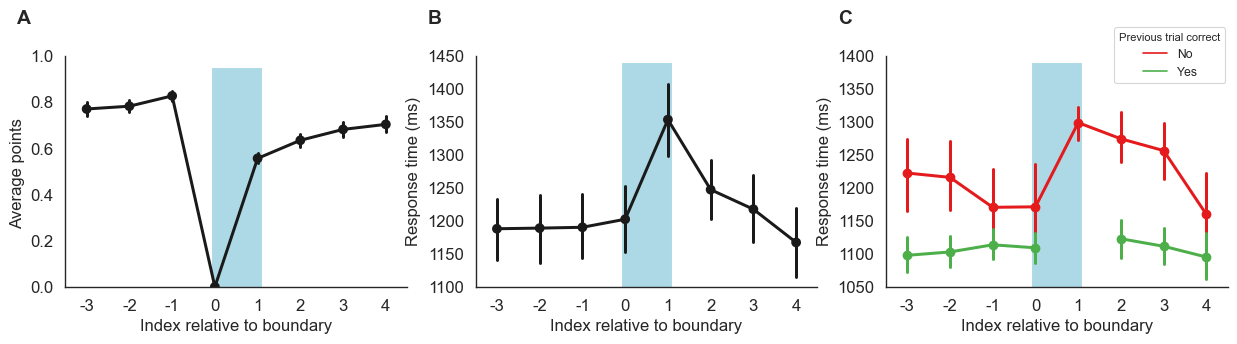

In [34]:
# Create a gridspec with width ratios [3, 2]
gs = gridspec.GridSpec(1, 3, wspace=0.2)

fig = plt.figure(figsize=(15, 3))
sns.despine()

# A
ax1 = plt.subplot(gs[0])
gb_df = (
    strat_df.groupby(["sona_id", "rel_subj_boundary"])["points", "rt"]
    .mean()
    .reset_index()
)
g = sns.pointplot(
    data=gb_df[gb_df["rel_subj_boundary"].isin(range(-3, 5))],
    y="points",
    ax=ax1,
    x="rel_subj_boundary",
    color="k",
)
g.set_ylabel("Average points ", fontsize=12)
g.set_xlabel("Index relative to boundary", fontsize=12)
g.add_patch(
    plt.Rectangle((2.9, 0), 1.2, 0.95, facecolor="#ADD8E6", edgecolor=None, zorder=0)
)
g.set_ylim(0, 1)
g.set_xticklabels(g.get_xticklabels(), fontsize=12)
g.set_yticklabels(g.get_yticklabels(), fontsize=12)

# B
ax2 = plt.subplot(gs[1])
g = sns.pointplot(
    data=gb_df[gb_df["rel_subj_boundary"].isin(range(-3, 5))],
    y="rt",
    ax=ax2,
    x="rel_subj_boundary",
    color="k",
)
g.set_ylabel("Response time (ms)", fontsize=12)
g.set_xlabel("Index relative to boundary", fontsize=12)
g.add_patch(
    plt.Rectangle((2.9, 1), 1.2, 1440, facecolor="#ADD8E6", edgecolor=None, zorder=0)
)
g.set_ylim(1100, 1450)
g.set_xticklabels(g.get_xticklabels(), fontsize=12)
g.set_yticklabels(g.get_yticklabels(), fontsize=12)
sns.despine()

# C
ax3 = plt.subplot(gs[2])
# g= sns.pointplot(data=subset_df,x='trial_within_block',y='rt',hue='prev_points',errorbar='ci',palette=pal,ax=ax3,
#  linestyles=['--','-'])
g = sns.pointplot(
    data=subset_df[subset_df["rel_subj_boundary"].isin(range(-3, 5))],
    x="rel_subj_boundary",
    y="rt",
    palette=pal,
    errorbar="ci",
    ax=ax3,
    hue="prev_points",
)
# g= sns.pointplot(data=subset_df[(subset_df['rel_subj_boundary'].isin(range(1,5))) & (subset_df['prev_points']==1)],x='rel_subj_boundary',y='rt',errorbar='ci',palette=[pal[1]],ax=ax3,hue='prev_points')
# # remove legend
# g= sns.pointplot(data=subset_df[(subset_df['rel_subj_boundary'].isin(range(-3,1))) & (subset_df['prev_points']==1)],x='rel_subj_boundary',y='rt',errorbar='ci',palette=[pal[1]],ax=ax3,hue='prev_points')
g.legend_.remove()

# remove legend
g.set_ylabel("Response time (ms)", fontsize=12)
g.set_xlabel("Index relative to boundary", fontsize=12)
g.set_xticklabels(g.get_xticklabels(), fontsize=12)
g.set_yticklabels(g.get_yticklabels(), fontsize=12)
# g.axvline(1,linestyle='--')
g.set_ylim(1100, 1450)
g.add_patch(plt.Rectangle((2.9, 1), 1.2, 1440, facecolor="#ADD8E6", zorder=0))
# g.add_patch(plt.Rectangle((3.8, 0), 1100, 1420, fill=None, edgecolor='grey', lw=2))
sns.despine()
# add a legend to C
legend_handles = [
    mlines.Line2D([], [], color=pal[0], linestyle="-", label="No"),
    mlines.Line2D([], [], color=pal[1], linestyle="-", label="Yes"),
]
# ax2.set_ylabel('Predicted probability of recall success',fontsize=10)
plt.legend(
    handles=legend_handles,
    title="Previous trial correct",
    bbox_to_anchor=(0.65, 1.15),
    title_fontsize="small",
)

sub_fig_labels = [(ax1, "A"), (ax2, "B"), (ax3, "C")]
for ax, label in sub_fig_labels:
    ax.text(
        -0.1,
        1.2,
        label,
        transform=ax.transAxes,
        fontsize=14,
        fontweight="bold",
        va="top",
        ha="right",
    )

fig.savefig("../../results/figs/encoding_perf.png", bbox_inches="tight", dpi=350)

# Figure 3: General recall characteristics

In [35]:
recalls = (fr_df.groupby(["subject"])["recalled"].sum() / 224).reset_index()
recalls["recalled"].describe()
print(f'Average proportion recalled is {np.round(recalls["recalled"].mean(),3)}')
print(f'Std of proportion recalled is {np.round(recalls["recalled"].std(),3)}')

Average proportion recalled is 0.175
Std of proportion recalled is 0.073


In [36]:
# plot setup
recall = fr.spc(fr_df)
lag_crp = fr.lag_crp(fr_df)
max_lag = 8
pos_lag_crp = lag_crp.query(f"0 < lag <= {max_lag}")
neg_lag_crp = lag_crp.query(f"{-max_lag} <= lag < 0")

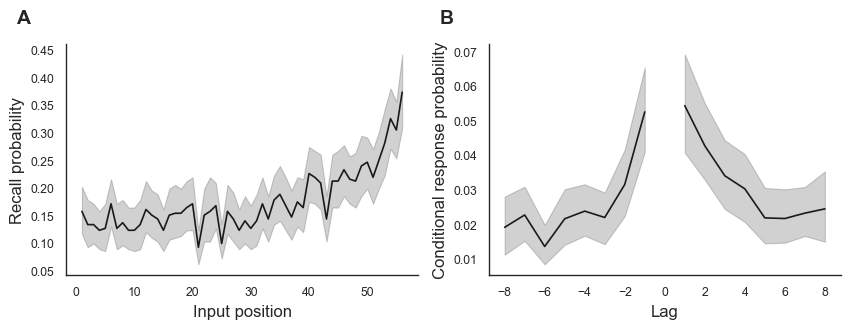

In [37]:
# Create a gridspec with width ratios [3, 2]
gs = gridspec.GridSpec(1, 2, wspace=0.2)

fig = plt.figure(figsize=(10, 3))
sns.despine()


# A
ax1 = plt.subplot(gs[0])
g = sns.lineplot(data=recall, x="input", y="recall", color="k", ax=ax1)
# g.set_xlabel('Run')
g.set_ylabel("Recall probability", fontsize=12)
g.set_xlabel("Input position", fontsize=12)
sns.despine()

# B
ax2 = plt.subplot(gs[1])
gpos = sns.lineplot(data=pos_lag_crp, x="lag", y="prob", ax=ax2, color="k")
gneg = sns.lineplot(data=neg_lag_crp, x="lag", y="prob", ax=ax2, color="k")
ax2.set_ylabel("Conditional response probability", fontsize=12)
ax2.set_xlabel("Lag", fontsize=12)
sns.despine()

# # C
# ax3 = plt.subplot(gs[2])
# sns.regplot(data=fr_df[fr_df['cumulative_points'].isin(range(8))],x='cumulative_points', y='recalled',logistic=True,scatter=False,color='k',ax=ax3)
# sns.despine()
# ax3.set_xlabel('Run length of correct points',fontsize=12)
# ax3.set_ylabel('Predicted probability of recall',fontsize=12)


sub_fig_labels = [(ax1, "A"), (ax2, "B")]
for ax, label in sub_fig_labels:
    ax.text(
        -0.1,
        1.15,
        label,
        transform=ax.transAxes,
        fontsize=14,
        fontweight="bold",
        va="top",
        ha="right",
    )

fig.savefig("../../results/figs/recall_perf.png", bbox_inches="tight", dpi=350)

In [38]:
# Fig 3A: recall proportion by points
# fr2 = fr_df[~fr_df['rel_subj_boundary'].isin([1])]
gb_df = fr_df.groupby(["subject", "points"])["recalled"].mean().reset_index()
# remove the within subject mean from both points
sub_means = fr_df.groupby("subject")["recalled"].mean()
gb_df = gb_df.merge(sub_means, on="subject", suffixes=("", "_mean"))

gb_df["recalled_minus_within"] = gb_df["recalled"] - gb_df["recalled_mean"]
# add back the grand_mean
gb_df["recalled_plus_grand_mean"] = (
    gb_df["recalled_minus_within"] + fr_df.recalled.mean()
)
gb_df

,subject,points,recalled,recalled_mean,recalled_minus_within,recalled_plus_grand_mean
0,53987712fdf99b68e3a45021,0.0,0.250000,0.257511,-0.007511,0.160336
1,53987712fdf99b68e3a45021,1.0,0.260355,0.257511,0.002844,0.170691
2,55885869fdf99b4020ba0b64,0.0,0.048077,0.078947,-0.030870,0.136976
3,55885869fdf99b4020ba0b64,1.0,0.104839,0.078947,0.025891,0.193738
4,55914b15fdf99b1e5e44e714,0.0,0.119565,0.129707,-0.010142,0.157705
...,...,...,...,...,...,...
141,65e7bb5a7357ea00136b0270,1.0,0.175758,0.176471,-0.000713,0.167134
142,65f223adc0810071f7cb1061,0.0,0.177966,0.171674,0.006292,0.174139
143,65f223adc0810071f7cb1061,1.0,0.165217,0.171674,-0.006456,0.161390
144,65f3bf636afc5f3102e7f2fd,0.0,0.164835,0.198312,-0.033477,0.134370


In [39]:
pg.ttest(
    gb_df.query("points == 0")["recalled"],
    gb_df.query("points == 1")["recalled"],
    paired=True,
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.453467,72,two-sided,0.01657,"[-0.03, -0.0]",0.202827,2.099,0.401365


# Figure 4: Effects of event boundaries on recall

In [40]:
blues = sns.color_palette("Blues", 6)
blues = blues[2:]

In [41]:
blues[0] = (0.5, 0.5, 0.5)

/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_22341/1657280202.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.round(ax1.get_yticks(),2),fontsize=fontsize)


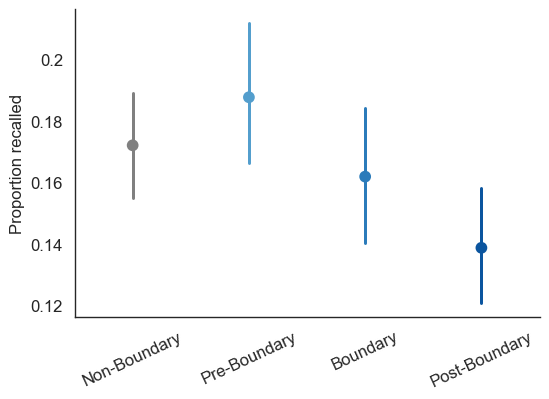

In [42]:
# Create a gridspec with width ratios [3, 2]
gs = gridspec.GridSpec(1, 1, wspace=0.2)
fontsize = 12
fig = plt.figure(figsize=(6, 4))
sns.despine()

# A
ax1 = plt.subplot(gs[0])
gb_df = fr_df.groupby(["subject", "boundary_label"])["recalled"].mean().reset_index()

g = sns.pointplot(
    data=gb_df,
    x="boundary_label",
    y="recalled",
    order=["Non-Boundary", "Pre-Boundary", "Boundary", "Post-Boundary"],
    palette=blues,
    errorbar="ci",
    scale=1.2,
)
sns.despine()
ax1.set_ylabel("Proportion recalled", fontsize=fontsize)
ax1.set_xlabel("")
ax1.set_xticklabels(
    ["Non-Boundary", "Pre-Boundary", "Boundary", "Post-Boundary"],
    rotation=25,
    fontsize=fontsize,
)
ax1.set_yticklabels(np.round(ax1.get_yticks(), 2), fontsize=fontsize)
# ax1.set_title('Response time changes by boundary position and reward')
sns.despine()


# g.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Rewarded at encoding')
# # change the legend labels from 0.0 and 1.0 to No and Yes
# new_labels = ['No', 'Yes']
# for t, l in zip(g.legend_.texts, new_labels): t.set_text(l)


# sub_fig_labels=[(ax2,"A"),(ax1,"B")]
# for ax, label in sub_fig_labels:
#     ax.text(-0.1, 1.15, label, transform=ax.transAxes,
#             fontsize=14, fontweight='bold', va='top', ha='right')

fig.savefig("../../results/figs/main_result.png", bbox_inches="tight", dpi=350)

In [43]:
pg.pairwise_tests(
    dv="recalled",
    within="boundary_label",
    subject="subject",
    data=gb_df,
    effsize="cohen",
)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,boundary_label,Boundary,Non-Boundary,True,True,-1.116332,72.0,two-sided,0.267992,0.234,-0.117713
1,boundary_label,Boundary,Post-Boundary,True,True,2.363258,72.0,two-sided,0.020818,1.728,0.260931
2,boundary_label,Boundary,Pre-Boundary,True,True,-2.174593,72.0,two-sided,0.032947,1.175,-0.263268
3,boundary_label,Non-Boundary,Post-Boundary,True,True,4.253866,72.0,two-sided,0.000062,317.161,0.422699
4,boundary_label,Non-Boundary,Pre-Boundary,True,True,-1.857633,72.0,two-sided,0.067310,0.655,-0.175257
5,boundary_label,Post-Boundary,Pre-Boundary,True,True,-4.551967,72.0,two-sided,0.000021,865.02,-0.535783


The above table contains all the pairwise tests for figure 4.

# Figure 5: Boundaries and events structure recall

In [44]:
# Defining a function to get the probability of a word transitioning to a boundary word


def get_stepping_stone(sub_df):
    """
    Calculates the probability that a given word between shifts is a boundary word
    """
    # now let's get all the recalled words
    recalled = sub_df[sub_df["recall"] & sub_df["study"]]
    recalled = recalled.sort_values(by=["output"]).reset_index(drop=True)
    # now within recalled, let's get the words that were recalled after a block shift
    recalled["block_shift"] = recalled["block"] != recalled["block"].shift(1)

    # now grab all the words that were recalled after a block shift and count them up by rel_subj_boundary
    return recalled[recalled["block_shift"]]["rel_subj_boundary"].value_counts(
        normalize=True
    )


# now let's apply this function to each subject and each list
stepping_stone = (
    fr_df.groupby(["sona_id", "list"]).apply(get_stepping_stone).reset_index()
)
stepping_stone.rename(
    columns={"level_2": "rel_subj_boundary", "rel_subj_boundary": "prob_position"},
    inplace=True,
)
# stepping_stone
stepping_stone = (
    stepping_stone.groupby(["sona_id", "rel_subj_boundary"])["prob_position"]
    .mean()
    .reset_index()
)
# stepping_stone = stepping_stone[stepping_stone['rel_subj_boundary'].isin(range(-4,5))].reset_index(drop=True)

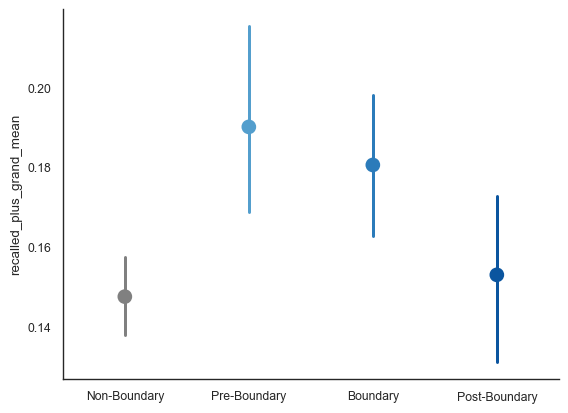

In [45]:
# bar plot of boundary vs non-boundary positions
# make a defaultdict for map of boundary labels where default is Non-boundary, 1 is Post-boundary 0 is Boundary and -1 is Pre-boundary


stepping_stone["boundary_label"] = stepping_stone["rel_subj_boundary"].apply(
    lambda x: boundary_labels[x] if x in boundary_labels else "Non-Boundary"
)
gb_df = (
    stepping_stone.groupby(["sona_id", "boundary_label"])["prob_position"]
    .mean()
    .reset_index()
)
gb_df = gb_df.pivot(
    index="sona_id", columns="boundary_label", values="prob_position"
).reset_index()
gb_df = gb_df.fillna(0)
gb_df = gb_df.melt(id_vars="sona_id", value_name="prob_position")
sub_means = gb_df.groupby("sona_id")["prob_position"].mean().reset_index()
gb_df = gb_df.merge(sub_means, on="sona_id", suffixes=("", "_mean"))
gb_df["recalled_minus_within"] = gb_df["prob_position"] - gb_df["prob_position_mean"]
gb_df["recalled_plus_grand_mean"] = (
    gb_df["recalled_minus_within"] + fr_df.recalled.mean()
)
g = sns.pointplot(
    data=gb_df,
    x="boundary_label",
    y="recalled_plus_grand_mean",
    palette=blues,
    order=["Non-Boundary", "Pre-Boundary", "Boundary", "Post-Boundary"],
    errorbar="ci",
    scale=1.5,
)
g.set_xlabel("")
sns.despine()

In [46]:
pg.pairwise_tests(
    dv="recalled_plus_grand_mean",
    within="boundary_label",
    subject="sona_id",
    data=gb_df,
    effsize="cohen",
)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,boundary_label,Boundary,Non-Boundary,True,True,2.861544,72.0,two-sided,0.005515,5.454,0.523971
1,boundary_label,Boundary,Post-Boundary,True,True,1.702241,72.0,two-sided,0.093024,0.507,0.322997
2,boundary_label,Boundary,Pre-Boundary,True,True,-0.551614,72.0,two-sided,0.582921,0.149,-0.106061
3,boundary_label,Non-Boundary,Post-Boundary,True,True,-0.456888,72.0,two-sided,0.649127,0.142,-0.075395
4,boundary_label,Non-Boundary,Pre-Boundary,True,True,-3.042113,72.0,two-sided,0.003277,8.64,-0.546379
5,boundary_label,Post-Boundary,Pre-Boundary,True,True,-1.790655,72.0,two-sided,0.077552,0.585,-0.383178


### Event based clustering

In [47]:
# get the clustering arc scores for each subject and label them by the block or correct rule
block_clust = fr.category_clustering(fr_df, category_key="block")
block_clust["category"] = "block"
cr_clust = fr.category_clustering(fr_df, category_key="item_rule")
cr_clust["category"] = "item_rule"

fr_df_no_post = fr_df[~fr_df["rel_subj_boundary"].isin([1])].reset_index(drop=True)
block_clust_no_post = fr.category_clustering(fr_df_no_post, category_key="block")
block_clust_no_post["category"] = "block_no_post"
cr_clust_no_post = fr.category_clustering(fr_df_no_post, category_key="item_rule")
cr_clust_no_post["category"] = "item_rule_no_post"


block_clust_no_post = block_clust_no_post.dropna(subset="arc")
cr_clust_no_post = cr_clust_no_post.dropna(subset="arc")

event_crp = fr.lag_crp(fr_df, lag_key="block")
event_crp

,subject,lag,prob,actual,possible
0,53987712fdf99b68e3a45021,-31.0,NaN,0,0
1,53987712fdf99b68e3a45021,-30.0,NaN,0,0
2,53987712fdf99b68e3a45021,-29.0,NaN,0,0
3,53987712fdf99b68e3a45021,-28.0,NaN,0,0
4,53987712fdf99b68e3a45021,-27.0,NaN,0,0
...,...,...,...,...,...
4594,65f3bf636afc5f3102e7f2fd,27.0,NaN,0,0
4595,65f3bf636afc5f3102e7f2fd,28.0,NaN,0,0
4596,65f3bf636afc5f3102e7f2fd,29.0,NaN,0,0
4597,65f3bf636afc5f3102e7f2fd,30.0,NaN,0,0


In [48]:
pg.ttest(
    event_crp.query("lag==1")["prob"], event_crp.query("lag==-1")["prob"], paired=True
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.715137,72,two-sided,0.090621,"[-0.0, 0.01]",0.293107,0.518,0.695267


In [49]:
event_crp = event_crp.dropna(subset="prob")
event_crp["forward_backward"] = event_crp["lag"].apply(
    lambda x: x if x in [-1, 0, 1] else "backward" if np.sign(x) == -1 else "forward"
)
forback_df = (
    event_crp[event_crp["lag"].isin(range(-8, 8))]
    .groupby(["subject", "forward_backward"])["prob"]
    .mean()
    .reset_index()
)
pg.ttest(
    forback_df[forback_df["forward_backward"] == "backward"]["prob"],
    forback_df[forback_df["forward_backward"] == "forward"]["prob"],
    paired=True,
)

/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_22341/1129614662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_crp['forward_backward'] = event_crp['lag'].apply(lambda x: x if x in [-1,0,1] else 'backward' if np.sign(x) == -1 else 'forward')


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-6.567025,72,two-sided,6.877378e-09,"[-0.01, -0.01]",1.111197,1.692e+06,1.0


In [50]:
pg.ttest(
    block_clust_no_post["arc"],
    block_clust.loc[block_clust["subject"].isin(block_clust_no_post["subject"]), "arc"],
    paired=True,
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.741227,72,two-sided,0.460967,"[-0.03, 0.06]",0.05701,0.168,0.076857


In [51]:
points_clust = fr.category_clustering(fr_df, category_key="points")
points_clust["category"] = "points"
points_clust["arc"].mean()
label_clust = fr.category_clustering(fr_df, category_key="rel_subj_boundary")
label_clust["category"] = "label"
label_clust["arc"].mean()

0.000266188889509386

In [52]:
# combine all the "clust" dataframes
clust_df = pd.concat([block_clust, cr_clust, points_clust, label_clust])
clust_df = clust_df.dropna(subset=["arc"])
Greys = sns.color_palette("Greys", 6)
Greys = Greys[2:]

In [53]:
clust_df = clust_df.merge(
    rl_df[["sona_id", "eta"]], left_on="subject", right_on="sona_id", how="left"
)

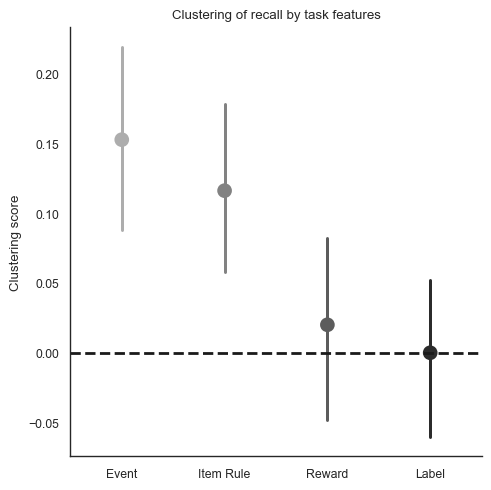

In [54]:
# plot the clustering arc scores
g = sns.catplot(
    data=clust_df,
    x="category",
    y="arc",
    kind="point",
    palette=Greys,
    scale=1.5,
    errorbar="ci",
)
g.ax.set_ylabel("Clustering score")
g.ax.set_xlabel("")
# g.ax.set_xticklabels(['Event','Item Rule'])
g.ax.set_title("Clustering of recall by task features")
g.ax.axhline(0.0, color="k", linestyle="--", linewidth=2)
g.set_xticklabels(["Event", "Item Rule", "Reward", "Label"])
sns.despine()

In [55]:
# do the pairwise comparisons of each clustering type in cluster df
print(
    pg.pairwise_tests(
        data=clust_df, dv="arc", within="category", subject="subject", effsize="cohen"
    )
)
print("\n")

print("\ntests against 0")
print("\n")
print(pg.ttest(clust_df.query('category=="block"')["arc"], 0))
print("\n")
print(pg.ttest(clust_df.query('category=="item_rule"')["arc"], 0))
print("\n")
print(pg.ttest(clust_df.query('category=="points"')["arc"], 0))
print("\n")
print(pg.ttest(clust_df.query('category=="label"')["arc"], 0))

   Contrast          A          B  Paired  Parametric         T   dof  \
0  category      block  item_rule    True        True  0.765038  72.0   
1  category      block      label    True        True  3.376376  72.0   
2  category      block     points    True        True  2.966829  72.0   
3  category  item_rule      label    True        True  2.544919  72.0   
4  category  item_rule     points    True        True  1.947906  72.0   
5  category      label     points    True        True -0.451141  72.0   

  alternative     p-unc    BF10     cohen  
0   two-sided  0.446749   0.171  0.134359  
1   two-sided  0.001187  21.429  0.554763  
2   two-sided  0.004081   7.113  0.460712  
3   two-sided  0.013074   2.573  0.449980  
4   two-sided  0.055325   0.767  0.353850  
5   two-sided  0.653244   0.142 -0.072905  



tests against 0


               T  dof alternative     p-val         CI95%   cohen-d     BF10  \
T-test  4.534095   72   two-sided  0.000023  [0.09, 0.22]  0.530676  813.622   

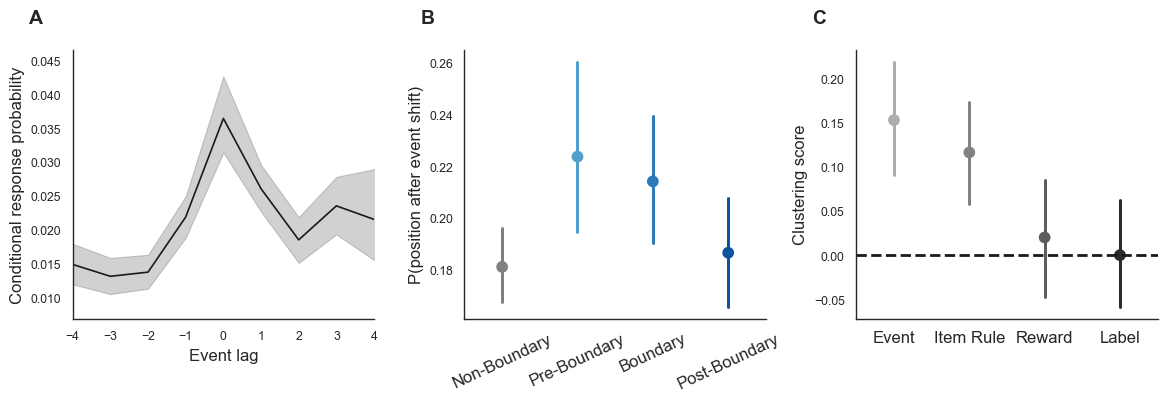

In [56]:
# # Create a gridspec with width ratios [3, 2]
gs = gridspec.GridSpec(1, 3, wspace=0.3)

fig = plt.figure(figsize=(14, 3.5))
sns.despine()

# A
ax1 = plt.subplot(gs[0])
max_lag = 4
event_crp = fr.lag_crp(fr_df, lag_key="block")

sns.lineplot(data=event_crp, x="lag", y="prob", color="k", ax=ax1)
ax1.set_ylabel("Conditional response probability", fontsize=12)
ax1.set_xlabel("Event lag", fontsize=12)
ax1.set_xlim(-max_lag, max_lag)
sns.despine()


# B
ax2 = plt.subplot(gs[1])

# sns.lineplot(data=neg_event_crp,x='lag',y='prob',color='k')

stepping_stone["boundary_label"] = stepping_stone["rel_subj_boundary"].apply(
    lambda x: boundary_labels[x] if x in boundary_labels else "Non-Boundary"
)
gb_df = (
    stepping_stone.groupby(["sona_id", "boundary_label"])["prob_position"]
    .mean()
    .reset_index()
)
gb_df = gb_df.pivot(
    index="sona_id", columns="boundary_label", values="prob_position"
).reset_index()
gb_df = gb_df.fillna(0)
gb_df = gb_df.melt(id_vars="sona_id", value_name="prob_position")
sub_means = gb_df.groupby("sona_id")["prob_position"].mean().reset_index()
gb_df = gb_df.merge(sub_means, on="sona_id", suffixes=("", "_mean"))
gb_df["recalled_minus_within"] = gb_df["prob_position"] - gb_df["prob_position_mean"]
gb_df["recalled_plus_grand_mean"] = (
    gb_df["recalled_minus_within"] + fr_df.recalled.mean()
)
g = sns.pointplot(
    data=gb_df,
    x="boundary_label",
    y="prob_position",
    palette=blues,
    order=["Non-Boundary", "Pre-Boundary", "Boundary", "Post-Boundary"],
    errorbar="ci",
    scale=1.2,
    ax=ax2,
)
g.set_ylabel("P(position after event shift)", fontsize=12)
g.set_xlabel("")
g.set_xticklabels(
    ["Non-Boundary", "Pre-Boundary", "Boundary", "Post-Boundary"],
    rotation=25,
    fontsize=12,
)
sns.despine()


# C
ax3 = plt.subplot(gs[2])
# plot the clustering arc scores
sub_means = clust_df.groupby("subject")["arc"].mean().reset_index()
gb_df = clust_df.merge(sub_means, on="subject", suffixes=("", "_mean"))
gb_df["recalled_minus_within"] = gb_df["arc"] - gb_df["arc_mean"]
gb_df["recalled_plus_grand_mean"] = (
    gb_df["recalled_minus_within"] + fr_df.recalled.mean()
)
g = sns.pointplot(
    data=gb_df, x="category", y="arc", palette=Greys, scale=1.2, errorbar="ci", ax=ax3
)
g.set_ylabel("Clustering score", fontsize=12)
g.set_xlabel("")
# g.set_title('Clustering of recall by task features')
g.axhline(0.0, color="k", linestyle="--", linewidth=2)
g.set_xticklabels(["Event", "Item Rule", "Reward", "Label"], fontsize=12)
sns.despine()

sub_fig_labels = [(ax1, "A"), (ax2, "B"), (ax3, "C")]
for ax, label in sub_fig_labels:
    ax.text(
        -0.1,
        1.15,
        label,
        transform=ax.transAxes,
        fontsize=14,
        fontweight="bold",
        va="top",
        ha="right",
    )

fig.savefig("../../results/figs/recall_seq_fig.png", bbox_inches="tight", dpi=350)

# Figure 6: RL model predicts recall

Using a logistic regression model, we can predict the probability of recalling an item given the boundary label of the item and the boundary label of the previous item.

In [57]:
subset_df = (
    strat_df.groupby(["sona_id", "trial_within_block"])["trial_by_trial_loglik"]
    .mean()
    .reset_index()
)
subset_df["trial_by_trial_lik"] = np.exp(subset_df["trial_by_trial_loglik"])
rpe_df = strat_df.groupby(["sona_id", "rel_subj_boundary"])["rpe"].mean().reset_index()

In [58]:
log_reg_df = fr_df[
    [
        "sona_id",
        "word",
        "rpe",
        "recall",
        "study",
        "points",
        "rel_subj_boundary",
        "run",
        "trial_within_block",
        "boundary_label",
    ]
]
log_reg_df["recall_success"] = log_reg_df["recall"] & log_reg_df["study"]
log_reg_df["recall_success"] = log_reg_df["recall_success"].astype(int)
log_reg_df = log_reg_df.dropna()
log_reg_df["abs_rpe"] = np.abs(log_reg_df["rpe"])
log_reg_df["val_rpe"] = np.sign(log_reg_df["rpe"])
log_reg_df["mean_cent_abs_rpe"] = log_reg_df["abs_rpe"] - log_reg_df["abs_rpe"].mean()
# log_reg_df = log_reg_df[log_reg_df['rel_subj_boundary'].isin(range(-3,5))].reset_index(drop=True)
model = Lmer(
    "recall_success ~ mean_cent_abs_rpe * val_rpe + (1|sona_id)+ (1|word)",
    data=log_reg_df,
    family="binomial",
)
model.fit()

/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_22341/4095993770.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_reg_df['recall_success'] = log_reg_df['recall'] & log_reg_df['study']
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_22341/4095993770.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_reg_df['recall_success'] = log_reg_df['recall_success'].astype(int)


Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: recall_success~mean_cent_abs_rpe*val_rpe+(1|sona_id)+(1|word)

Family: binomial	 Inference: parametric

Number of observations: 16767	 Groups: {'word': 432.0, 'sona_id': 73.0}

Log-likelihood: -7350.297 	 AIC: 14712.594

Random effects:

                Name    Var    Std
word     (Intercept)  0.201  0.448
sona_id  (Intercept)  0.245  0.495

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.702,-1.837,-1.567,0.069,0.182,0.159,0.209,0.154,0.137,0.173,-24.651,0.000,***
mean_cent_abs_rpe,-0.036,-0.196,0.125,0.082,0.965,0.822,1.133,0.491,0.451,0.531,-0.436,0.663,
val_rpe,0.033,-0.023,0.089,0.028,1.034,0.978,1.093,0.508,0.494,0.522,1.168,0.243,
mean_cent_abs_rpe:val_rpe,-0.242,-0.423,-0.060,0.093,0.785,0.655,0.941,0.440,0.396,0.485,-2.612,0.009,**


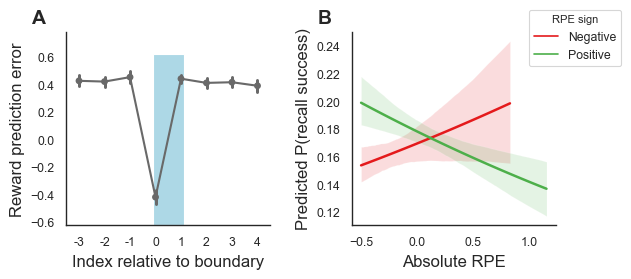

In [59]:
# Create a gridspec with width ratios [3, 2]
gs = gridspec.GridSpec(1, 3, wspace=0.4)

fig = plt.figure(figsize=(10, 2.5))
sns.despine()


# A
ax1 = plt.subplot(gs[0])
rpe_df = strat_df.groupby(["sona_id", "rel_subj_boundary"])["rpe"].mean().reset_index()
g = sns.pointplot(
    data=rpe_df,
    x="rel_subj_boundary",
    y="rpe",
    color="dimgrey",
    ax=ax1,
    order=range(-3, 5),
    errorbar="ci",
    scale=0.7,
)
g.set_ylabel("Reward prediction error", fontsize=12)
g.set_xlabel("Index relative to boundary", fontsize=12)
g.add_patch(
    plt.Rectangle(
        (2.9, -0.62), 1.2, 1.24, facecolor="#ADD8E6", edgecolor=None, zorder=0
    )
)
g.set_ylim(-0.62, 0.78)
sns.despine()

# B
ax2 = plt.subplot(gs[1])
sns.regplot(
    data=log_reg_df.query("val_rpe==-1"),
    x="mean_cent_abs_rpe",
    y="recall_success",
    scatter=False,
    logistic=True,
    ax=ax2,
    color=pal[0],
)
sns.regplot(
    data=log_reg_df.query("val_rpe==1"),
    x="mean_cent_abs_rpe",
    y="recall_success",
    scatter=False,
    logistic=True,
    ax=ax2,
    color=pal[1],
)
# add in legend


sns.despine()
legend_handles = [
    mlines.Line2D([], [], color=pal[0], label="Negative"),
    mlines.Line2D([], [], color=pal[1], label="Positive"),
]

# Add custom legend to the plot
plt.legend(
    handles=legend_handles,
    title="RPE sign",
    bbox_to_anchor=(1.35, 1.15),
    title_fontsize="small",
)
ax2.set_xlabel("Absolute RPE", fontsize=12)
ax2.set_ylabel("Predicted P(recall success)", fontsize=12)


sub_fig_labels = [(ax1, "A"), (ax2, "B")]
for ax, label in sub_fig_labels:
    ax.text(
        -0.1,
        1.12,
        label,
        transform=ax.transAxes,
        fontsize=14,
        fontweight="bold",
        va="top",
        ha="right",
    )

fig.savefig("../../results/figs/rl_fig.png", bbox_inches="tight", dpi=350)